In [ ]:
import pickle as pkl 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import utils
import models
import GraphKernel

In [ ]:
path = 'data/'
with open(path + 'training_data.pkl', 'rb') as file: 
    train_graphs = pkl.load(file) 

with open(path + 'test_data.pkl', 'rb') as file: 
    test_graphs = pkl.load(file) 
    
with open(path + 'training_labels.pkl', 'rb') as file: 
    train_labels = pkl.load(file) 

In [ ]:
for G in train_graphs:
    for e in G.nodes:
        G.nodes[e]['labels'] = [G.nodes[e]['labels'][0], 1]

for G in test_graphs:
    for e in G.nodes:
        G.nodes[e]['labels'] = [G.nodes[e]['labels'][0], 1]

for G in train_graphs:
    for e in G.edges:
        G.edges[e]['labels'] = G.edges[e]['labels'][0] + 1

for G in test_graphs:
    for e in G.edges:
        G.edges[e]['labels'] = G.edges[e]['labels'][0] + 1
        

In [ ]:
import copy
def morgan_index(graphs):
    
    for (i,G) in enumerate(graphs):
        K = copy.deepcopy(G)
        for node in G.nodes:
            K.nodes[node]['labels'][1] = 0
            for x in G.neighbors(node):
                K.nodes[node]['labels'][1]  += G.nodes[x]['labels'][1]
        graphs[i] = K 

In [ ]:
for i in range(1):
    morgan_index(train_graphs)
    morgan_index(test_graphs)

In [ ]:
one_train = []
zero_train = []
for (i,G) in enumerate(train_graphs):
    if(train_labels[i] == 0):
        zero_train.append(G)
    else:
        one_train.append(G)    

In [ ]:
n = 6000
train_graphs = one_train
train_labels = [1]*len(one_train)
for G in zero_train:
    if(len(train_graphs) == n):
        break
    train_graphs.append(G)
    train_labels.append(0)


In [ ]:
zero_train = zero_train[n:]
y_zeros = np.zeros(len(zero_train))

In [ ]:
len(zero_train)

In [ ]:
randomWalk = GraphKernel.WalkKernel(maxK = 100)  
shortestPath = GraphKernel.ShortestPath()

K_train = shortestPath.compute_kernel(train_graphs,train_graphs)  #+ randomWalk.compute_kernel(train_graphs,train_graphs)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from tqdm import tqdm

c = np.arange(1,1.5,0.01)
scores = []
for C in tqdm(c):
    for i in range(2):
        s = []
        skf = KFold(n_splits=5, random_state=i, shuffle=True)
        score = cross_val_score(SVC(C = C, kernel='precomputed',  probability=True, class_weight='balanced'), K_train, train_labels, cv=skf, scoring = 'roc_auc')
        s.append(score.reshape(-1))
    scores.append(np.mean(s))

C =  c[np.argsort(scores)[-1]]
print(scores)
print(C,np.sort(scores)[-1])

In [ ]:
print(C,np.sort(scores)[-1])

## Make Prediction

In [147]:
K_test = shortestPath.compute_kernel(test_graphs,train_graphs)  #randomWalk.compute_kernel(test_graphs,train_graphs) + 

100%|██████████| 2000/2000 [07:44<00:00,  4.31it/s]


In [231]:
import cvxopt
import cvxopt.solvers
from sklearn.base import BaseEstimator, ClassifierMixin

def to_binary(y):
    return ((y + 1) / 2).astype(int)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

class KernelSVC(BaseEstimator, ClassifierMixin):
    
    def __init__(self, C, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                                     
        self.alpha = None
        self.epsilon = epsilon
        self.norm_f = None
        self.a = None
       
    
    def fit(self, K_train, y):
        y = np.array(y)
       
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        
        # Lagrange dual problem
        def loss(alpha):
            #'''--------------dual loss ------------------ '''
            return (1/2)*((np.diag(y)@alpha.reshape(-1,1)).T@K_train@(np.diag(y)@alpha.reshape(-1,1))) - np.sum(alpha)
        
        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            # '''----------------partial derivative of the dual loss wrt alpha -----------------'''
            return np.diag(y)@K_train@np.diag(y)@alpha.reshape(-1,1) - 1
        
      
        # Set up quadratic programming problem
        P = cvxopt.matrix(np.outer(y, y) * K_train)
        q = cvxopt.matrix(-1 * np.ones(N))
        G = cvxopt.matrix(np.vstack((-1 * np.eye(N), np.eye(N))))
        h = cvxopt.matrix(np.hstack((np.zeros(N), self.C * np.ones(N))))
        A = cvxopt.matrix(y.reshape(1, -1)) * 1.0
        b = cvxopt.matrix(np.zeros(1))
        # Solve the quadratic program using cvxopt       
        cvxopt.solvers.options['show_progress'] = True
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        alpha = np.array(solution['x']).flatten()
        
        
        #clip
        self.alpha[self.alpha < 1e-5] = 0
        ## Assign the required attributes
        self.a = np.diag(y)@self.alpha 
        f = K_train@self.a
        mask = ((self.alpha < self.C) & (self.alpha > 0))
        mask = (self.alpha < self.C)
        self.b =  np.median((1 - y[mask]*f[mask])/y[mask]) #''' -----------------offset of the classifier------------------ '''
        self.norm_f = self.a.T@K_train@self.a   #'''------------------------RKHS norm of the function f ------------------------------'''
       

    ### Implementation of the separting function $f$ 
    def separating_function(self, K_test):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return K_test@self.a
    
    
    def predict(self, K_test):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(K_test)
        return 2 * ((d+self.b)> 0) - 1
    
    def predict_proba(self, X):
        d = self.separating_function(X)
        return sigmoid(d + self.b)
    
    


In [233]:
y_train = train_labels
y_train = np.array(y_train).reshape(-1)
y_train = 2*y_train - 1 

In [236]:
np.unique(y_train,return_counts=True)

(array([-1,  1]), array([5445,  555], dtype=int64))

In [237]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True, class_weight='balanced')
clf = KernelSVC(C=1)
# Fit on the train Kernel
clf.fit(K_train, y_train)

# Predict and test.
y_pred = clf.predict(K_train)

print("Classification accuracy: %0.2f" % accuracy_score(y_train, y_pred))

     pcost       dcost       gap    pres   dres
 0: -9.8717e+01 -8.6443e+03  4e+04  2e+00  4e-12
 1: -6.7626e+01 -4.0516e+03  8e+03  3e-01  5e-12
 2: -6.3199e+01 -1.2327e+03  2e+03  6e-02  5e-12
 3: -6.5401e+01 -5.4400e+02  7e+02  2e-02  4e-12
 4: -6.8633e+01 -2.2187e+02  2e+02  4e-03  4e-12
 5: -7.1537e+01 -1.2595e+02  7e+01  1e-03  4e-12
 6: -7.3170e+01 -9.6515e+01  3e+01  3e-04  3e-12
 7: -7.4586e+01 -8.4774e+01  1e+01  8e-05  3e-12
 8: -7.5791e+01 -7.7920e+01  2e+00  2e-14  4e-12
 9: -7.6205e+01 -7.6956e+01  8e-01  1e-13  3e-12
10: -7.6378e+01 -7.6584e+01  2e-01  2e-14  4e-12
11: -7.6434e+01 -7.6478e+01  4e-02  9e-14  4e-12
12: -7.6450e+01 -7.6452e+01  2e-03  6e-14  4e-12
13: -7.6450e+01 -7.6450e+01  1e-04  4e-15  4e-12
14: -7.6450e+01 -7.6450e+01  3e-06  8e-15  4e-12
Optimal solution found.


TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [ ]:
print(clf.b)

-1.0


In [209]:
print("Classification accuracy: %0.2f" % accuracy_score(y_train, y_pred))

Classification accuracy: 0.91


In [210]:
np.unique(y_pred,return_counts=True)

(array([-1]), array([6000], dtype=int64))

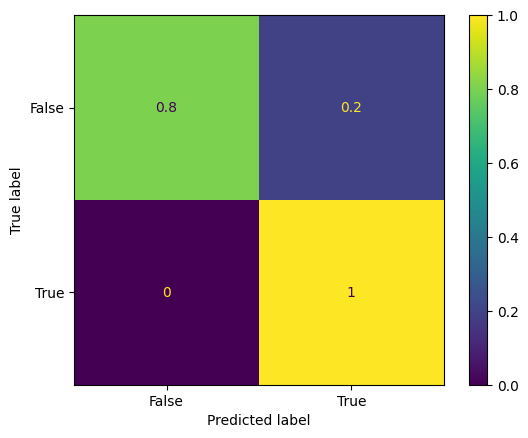

In [160]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred = clf.predict(K_train)
#tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
confusion_matrix = confusion_matrix(y_train, y_pred,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [138]:
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, K_train, y_train)

C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


AttributeError: 'KernelSVC' object has no attribute 'classes_'

In [169]:
y_pred = clf.predict_proba(K_test)
y_pred = np.log(y_pred/(1-y_pred))
y_pred

array([-0.07839961,  1.88339152, -3.72623978, ..., -0.51166172,
        2.35917314, -0.36969519])

In [170]:
sub = pd.DataFrame()
sub['Id']= np.arange(1,len(y_pred)+1)
sub['Predicted'] = y_pred
sub.to_csv("submissions/sub.csv",index=False)

In [171]:
y_sub = pd.read_csv("submissions/sub.csv")
y_sub = np.array(y_sub['Predicted'])
y_sub[y_sub< 0 ] = 0
y_sub[y_sub>0] = 1
np.sum(y_sub)/len(y_sub)

0.443

In [172]:
y_sub = pd.read_csv("submissions/sub_089.csv")
y_sub = np.array(y_sub['Predicted'])
y_sub[y_sub< 0 ] = 0
y_sub[y_sub>0] = 1
np.sum(y_sub)/len(y_sub)

0.111